In [75]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.style.use("default")

### Defining initial factors

figures out the number of arrows from the density and the size of the box $N = \rho L^2$ as it is in 2D

\begin{equation}
v_0 = \frac{r_0}{\Delta t }* Factor
\end{equation}

- `factor` is just used to scale the veloctiy
- `deltat` used to figure out the veloctiy too
- `iterations` is useless

In [76]:
L = 32.0
rho = 3.0
N = int(rho*L**2)
print(" N",N)
 
r0 = 1.0
deltat = 1.0
factor =0.5
v0 = r0/deltat*factor
iterations = 10000
eta = 0.15

 N 3072


- `pos` is an (N,2) array showing the x,y coords
- `orient` is an N length array for the angle of each arrow

In [77]:
pos = np.random.uniform(0,L,size=(N,2))
orient = np.random.uniform(-np.pi, np.pi,size=N)

print("pos shape: ", pos.shape)
print(pos)

print("orient shape:", orient.shape)
print(orient)


pos shape:  (3072, 2)
[[19.83112667 31.12412262]
 [24.05479029 21.93370177]
 [ 4.40932359 18.67717503]
 ...
 [29.08145124 12.74235765]
 [30.50142741  6.23487232]
 [ 6.84944127  6.19746972]]
orient shape: (3072,)
[ 2.71918641  1.09413159  2.91391382 ...  1.63960827  2.30172591
 -1.80368846]


plots the arrows

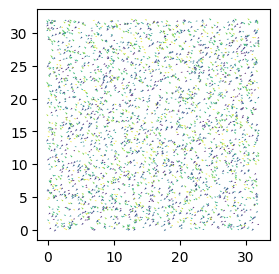

In [78]:
fig, ax= plt.subplots(figsize=(3,3))
 
qv = ax.quiver(pos[:,0], pos[:,1], np.cos(orient[0]), np.sin(orient), orient, clim=[-np.pi, np.pi])

## Animate function

### Calculating the distances between particles
- **`global`** is a word used to define a variable that may already be outside of the function. So instead of the function only looking inside the function for other times it is declared it pays attention to when it is defined outside.

    Here it is used to look at the orientation that was defined before

- **`cKDTree`** - forms a kd-tree that can be used for quick nearest neighbour lookup. So sets up for the `sparse_distance_matrix`. It works by producing a `class` of which `sparse_distance_matrix` is inside of.

- **`sparse_distance_matrix`** - computes a distance matrix between 2 cKDTrees. Here is is the distances between the `tree` and `tree` again, done by `tree1.sparse_distance_matrix(tree2,...)`. This finds the distances between each particle. `r0` is recalled as the `max_distance`, so the output for any distance greater than `r0` is left as blank. This makes it store so many less values than the nxn matrix as the nxn matrix stores anything greater than `r0` as a 0.

    The output as a coo_matrix stores the index's to the particles in a nxn for $r_{A,B}<r0$ and then the distance that that is ($r_{A,B}$). 

In [79]:
tree = cKDTree(pos,boxsize=[L,L])
print(tree.data)

[[19.83112667 31.12412262]
 [24.05479029 21.93370177]
 [ 4.40932359 18.67717503]
 ...
 [29.08145124 12.74235765]
 [30.50142741  6.23487232]
 [ 6.84944127  6.19746972]]


In [80]:
dist = tree.sparse_distance_matrix(tree, max_distance=r0,output_type='coo_matrix')
print(f"Number of values stored: \n Sparse matrix: {dist.nnz},\n nxn matrix: {N**2}")

print(f"nxn has {N**2/dist.nnz:.3f}x more values stored")
print(dist)

Number of values stored: 
 Sparse matrix: 31896,
 nxn matrix: 9437184
nxn has 295.874x more values stored
<COOrdinate sparse matrix of dtype 'float64'
	with 31896 stored elements and shape (3072, 3072)>
  Coords	Values
  (817, 817)	0.0
  (817, 1119)	0.7719140501021693
  (817, 21)	0.6276199086085993
  (817, 239)	0.9442035785651391
  (817, 2858)	0.7269364355430008
  (817, 503)	0.3861492498033151
  (817, 811)	0.3525127649996974
  (817, 1833)	0.3363816241108447
  (1119, 817)	0.7719140501021693
  (1119, 1119)	0.0
  (1119, 21)	0.7621242642877113
  (1119, 239)	0.23202676580215587
  (1119, 2858)	0.4784123391992008
  (1119, 503)	0.8927973648241271
  (1119, 886)	0.9989278721242895
  (21, 817)	0.6276199086085993
  (21, 1119)	0.7621242642877113
  (21, 21)	0.0
  (21, 239)	0.9941354563831297
  (21, 503)	0.9993245354852888
  (21, 811)	0.9177022106001894
  (21, 1833)	0.6310482326045649
  (76, 76)	0.0
  (76, 3058)	0.7426103324772234
  (76, 886)	0.7602377940251257
  :	:
  (726, 2548)	0.5793663895718095


### Calculating the new angle
- **`data = np.exp(orient[dist.col]*1j)`**

    Gets the index for all the values with distance $<r_0$>, finds their angles from the `orient` matrix. Then puts into $e^{i \theta}$ to get a complext number with modulus 1.

- **`neigh = sparse.coo_matrix(...)`**

    Puts all the complex numbers from the filtered complex orientation matrix `data` and puts it into a sparse matrix.

- **`np.squeeze(np.asarray(....))`**

    Sums along all of the columns to get the new complex number for each particle. This then relates to the new average angle for the particle

- **`np.angle(S) + eta*np.random.unifrom(...)`**

    turns the previous complex numbers into the new angle plus a little bit of noise.


In [81]:
#important 3 lines: we evaluate a quantity for every column j
data = np.exp(orient[dist.col]*1j)

print("complex numbers of particles r<r0:", data)

neigh = sparse.coo_matrix((data,(dist.row,dist.col)), shape=dist.get_shape())

# print(neigh)
# and sum along the columns (sum over j)
S = np.squeeze(np.asarray(neigh.tocsr().sum(axis=1)))
print("Sum of those comlex numbers:", S)

orient = np.angle(S)+eta*np.random.uniform(-np.pi, np.pi, size=N)
print("New angle in radians:",orient)

complex numbers of particles r<r0: [ 0.72548175+0.6882414j  -0.85539033+0.51798396j -0.71692336+0.69715199j
 ...  0.96369657-0.26699984j  0.89293419-0.45018722j
  0.81279561-0.58254896j]
Sum of those comlex numbers: [-3.02930385+0.27391151j  0.12672724-0.03355749j -1.9935501 +0.60854442j
 ... -2.84599826+1.46726061j  0.04839467+2.94655147j
  3.54404005+1.71469574j]
New angle in radians: [2.98585952 0.14636956 2.96555787 ... 2.99151007 1.77832295 0.3919433 ]


### Updating the position with periodic boundary conditions
Updates the new position based on the angle and breaking the velocity down into x,y components for that velocity.

\begin{equation}
s_{n+1} = s_n +v cos(\theta)\Delta t
\end{equation}

noticed a deltat missing

In [82]:
cos, sin= np.cos(orient), np.sin(orient)
pos[:,0] += cos*v0*deltat
pos[:,1] += sin*v0*deltat

pos[pos>L] -= L
pos[pos<0] += L

`qv.set_offsets(pos)` resests the position of the arrow.
`qv.set_UVC(cos, sin,orient)` resets the angle and colour (from `orient`) of the arrow.


This `animate` function just updates the step. The `FuncAnimation` then does uses `animate` to conitue the simulation to the limit specified in the `arange`. However for me the ainmation keepings running after the range but when I save it, it only runs to the limit.